In [8]:
"""
孔老师提供的同源表里的光谱命名方式如下
不同数量的字符有不同的含义
"""

import os
from astropy.io import fits

root = '/mnt/remote/lamost/spectra_v2.9.8/'
target = '20170926HIP4323K201017'

date = target[:8]
folder = target[8:-5]
id1 = os.listdir(os.path.join(root, date, folder))[0].split('-')[1]
sp = target[-5:-3]
id2 = target[-3:]
filename = 'spec-{}-{}_sp{}-{}.fits'.format(id1, folder, sp, id2)
filepath = os.path.join(root, date, folder, filename)

## 获取 Kepler 观测时间内的光谱

### 观测时间内的光谱

交叉步骤：
1. 根据 ra、dec 交叉两者的 catalog，这一步很久之前用 topcat 做过，这里记为 kep_lam_pos。
2. kep_lam_pos 中包含光变曲线和光谱的观测时间，卡 mjd 在 ktc_obsv_start_mjd 和 ktc_obsv_stop_mjd 之间的条目，这一步记为 kep_lam_mjd。
3. 根据 kep_lam_mjd 中的 sci_data_set_name 去和 kep_flare_ev 交叉，拿到有光谱观测的耀发时间列表，记为 kep_lam_flare。

注意可能存在的问题：
1. kepler_lamost_possion 的交叉是以光变曲线和光谱进行位置最优匹配的，有可能存在匹配不全的问题，因为是多对多的问题。
2. kepler_lamost_mjd 这一步的交叉卡的可能有点死，可能的导致召回降低。

如果做的不好，可以考虑整理两个以星为单位的表，然后用 topcat 做交叉。



In [1]:
import pandas as pd

# load kepler_lamost_possion by topcat
kep_lam_pos = pd.read_csv('/home/jmh/Datasets/kepler_k2_lamost/match_kepler_lamostdr9.csv.gz')
print('kep_lam_pos.shape: ', kep_lam_pos.shape)
print(list(kep_lam_pos.columns))

# cross match by mjd
kep_lam_mjd = kep_lam_pos[(kep_lam_pos['mjd'] > kep_lam_pos['ktc_obsv_start_mjd']) & \
                          (kep_lam_pos['mjd'] < kep_lam_pos['ktc_obsv_stop_mjd'])]
print('kep_lam_mjd.shape: ', kep_lam_mjd.shape)
kep_lam_mjd.to_csv('/home/jmh/Datasets/kepler_k2_lamost/kep_lam_mjd.csv.gz', index=False)

# cross match by sci_data_set_name
kep_flare_ev = pd.read_csv('/home/jmh/Datasets/kepler_k2_lamost/kep_flare_ev.csv')
print('kep_flare_ev.shape: ', kep_flare_ev.shape)
print(list(kep_flare_ev.columns))
kep_lam_flare = pd.merge(kep_lam_mjd, kep_flare_ev, on='sci_data_set_name', how='inner')
print('kep_lam_flare.shape: ', kep_lam_flare.shape)
kep_lam_flare.to_csv('/home/jmh/Datasets/kepler_k2_lamost/kep_lam_flare.csv.gz', index=False)

kep_lam_pos.shape:  (1302011, 114)
['ktc_investigation_id', 'ktc_kepler_id', 'ktc_target_type', 'ktc_obsv_start_mjd', 'ktc_obsv_stop_mjd', 'ktc_obsv_start_time', 'ktc_obsv_stop_time', 'ktc_act_obsv_start_mjd', 'ktc_act_obsv_stop_mjd', 'ktc_act_obsv_start_time', 'ktc_act_obsv_stop_time', 'sci_ra', 'sci_dec', 'kic_pmra', 'kic_pmdec', 'kic_umag', 'kic_gmag', 'kic_rmag', 'kic_imag', 'kic_zmag', 'kic_gredmag', 'kic_d51mag', 'twoMass_jmag', 'twoMass_hmag', 'twoMass_kmag', 'kic_kepmag', 'twoMass_tmid', 'kic_scpid', 'kic_altid', 'kic_altsource', 'kic_galaxy', 'kic_blend', 'kic_variable', 'kic_teff', 'kic_logg', 'kic_feh', 'kic_ebminusv', 'kic_av', 'kic_radius', 'kic_cq', 'kic_pq', 'kic_aq', 'kic_catkey', 'kic_scpkey', 'kic_parallax', 'kic_glon', 'kic_glat', 'kic_pmtotal', 'kic_grcolor', 'twoMass_jkcolor', 'twoMass_gkcolor', 'twoMass_2mass_id', 'sci_archive_class', 'sci_data_set_name', 'refnum', 'sci_pep_id', 'sci_start_time', 'sci_end_time', 'sci_release_date', 'sci_generation_date', 'sci_data

### 多次光谱观测的星

lam_dr9_lrs_simple.csv.gz 是 dr9 低分辨的光谱catalog，做了简化处理，只保留 uid obsid ra dec 等信息。

步骤：
1. kep_lam_flare 中的 uid 去重，得到 kep_lam_uid。
2. 遍历 kep_lam_uid，筛选 lam_dr9_lrs_simple 中对应 uid 有多次观测的 obsid 列表。
3. 最终得到的结果是一个 dict，有以下键值：
    - ktc_kepler_id
    - uid
    - obs_spec: 观测到的光谱的信息，类型为 DataFrame，与官网保存的 csv 列名相同
    - flare_ev: 耀发的信息，类型为 DataFrame，包括 ktc_kepler_id, quarter, start, end, duration, energy

结果保存路径：/home/jmh/Datasets/kepler_k2_lamost/mult_spec_w_flare.pickle

In [7]:
import pandas as pd
from tqdm import tqdm

kep_lam_flare = pd.read_csv('/home/jmh/Datasets/kepler_k2_lamost/kep_lam_flare.csv.gz')
kep_lam_flare_drop = kep_lam_flare.drop_duplicates(subset=['ktc_kepler_id_x'])
kep_lam_flare_drop = kep_lam_flare_drop[['ktc_kepler_id_x', 'uid']]

lam_simple = pd.read_csv('/home/jmh/Datasets/kepler_k2_lamost/lam_dr9_lrs_simple.csv.gz')
print('lam_simple.shape: ', lam_simple.shape)

target_obs_id = {}
for uid in tqdm(kep_lam_flare_drop['uid'].tolist()):
    tmp = lam_simple[lam_simple['uid'] == uid]
    if tmp.shape[0] > 1:
        target_obs_id[uid] = tmp['obsid'].tolist()
print(len(target_obs_id.keys()))

lam_simple.shape:  (11211028, 6)


100%|██████████| 105/105 [00:59<00:00,  1.77it/s]

38


In [23]:
import pickle

obs_info = pd.read_csv('/home/jmh/Datasets/kepler_k2_lamost/obs_info.csv')
res = []
for uid in tqdm(target_obs_id.keys()):
    item = {}

    ktc_kepler_id = kep_lam_flare_drop[kep_lam_flare_drop['uid'] == uid]['ktc_kepler_id_x'].tolist()[0]
    flare_ev = kep_flare_ev[kep_flare_ev['ktc_kepler_id'] == ktc_kepler_id]

    obsid_list = target_obs_id[uid]
    obs_spec = pd.DataFrame()
    for obsid in obsid_list:
        tmp = obs_info[obs_info['obsid'] == obsid]
        obs_spec = pd.concat([obs_spec, tmp])
    
    item['uid'] = uid
    item['ktc_kepler_id'] = ktc_kepler_id
    item['obs_spec'] = obs_spec
    item['flare_ev'] = flare_ev

    res.append(item)

with open('/home/jmh/Datasets/kepler_k2_lamost/mult_spec_w_flare.pickle', 'wb') as f:
    pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 38/38 [00:00<00:00, 578.60it/s]


### 多次光谱观测分析

统计 flare 时间和多次 spec 观测时间

In [8]:
import pickle

from astropy.time import Time
import pandas as pd

with open('/data/kepler_k2_lamost/mult_spec_w_flare.pickle', 'rb') as f:
    data = pickle.load(f)

# 统计 flare 同一年的 spec 观测
idx_candence = []
for i in range(len(data)):
    item = data[i]
    obs_spec = item['obs_spec']
    flare_ev = item['flare_ev']

    spec_time = Time(obs_spec['mjd'].tolist(), format='mjd').to_datetime()
    flare_jd = flare_ev['start'] + 2454833.0
    flare_time = Time(flare_jd, format='jd').to_datetime()
    spec_year = [x.year for x in spec_time]
    flare_year = [x.year for x in flare_time if x.year in spec_year]

    if len(flare_year) > 1:
        idx_candence.append(i)
        print(i)
        print(spec_year)
        print(flare_year)
        print('--------------------')

print(idx_candence)

1
[2012, 2018]
[2012, 2012, 2012, 2012, 2012, 2012, 2012]
--------------------
2
[2012, 2012, 2015, 2017]
[2012, 2012, 2012, 2012, 2012, 2012]
--------------------
3
[2012, 2017]
[2012, 2012, 2012, 2012]
--------------------
5
[2012, 2012, 2021]
[2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012]
--------------------
6
[2012, 2012]
[2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012]
--------------------
7
[2012, 2015, 2017]
[2012, 2012, 2012, 2012, 2012, 2012, 2012]
--------------------
8
[2012, 2013, 2014]
[2013, 2013, 2013, 2013, 2013, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013, 2012, 2012, 2012, 2012, 2013]
--------------------
9
[2012, 2017]
[2012, 2012, 2012, 2012]
--------------------
10
[2012, 2012]
[2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 201

In [21]:
# 看看有没有前后几个月的
import datetime

deta_days = 7

for i in idx_candence:
    item = data[i]
    obs_spec = item['obs_spec']
    obs_spec = obs_spec.reset_index()
    flare_ev = item['flare_ev']

    spec_time = Time(obs_spec['mjd'].tolist(), format='mjd').to_datetime()
    flare_jd = flare_ev['start'] + 2454833.0
    flare_time = Time(flare_jd, format='jd').to_datetime()
    
    for j in range(len(flare_time)):
        start_range = flare_time[j] - datetime.timedelta(days=deta_days)
        end_range = flare_time[j] + datetime.timedelta(days=deta_days)

        for k in range(len(obs_spec)):
            if start_range <= spec_time[k] <= end_range:
                print(i, j, k)
                print(flare_time[j])
                print(spec_time[k])
                print('---------------')

6 10 0
2012-06-13 16:51:36.000011
2012-06-15 00:00:00
---------------
6 10 1
2012-06-13 16:51:36.000011
2012-06-17 00:00:00
---------------
10 121 0
2012-06-15 12:30:23.040001
2012-06-15 00:00:00
---------------
10 121 1
2012-06-15 12:30:23.040001
2012-06-17 00:00:00
---------------


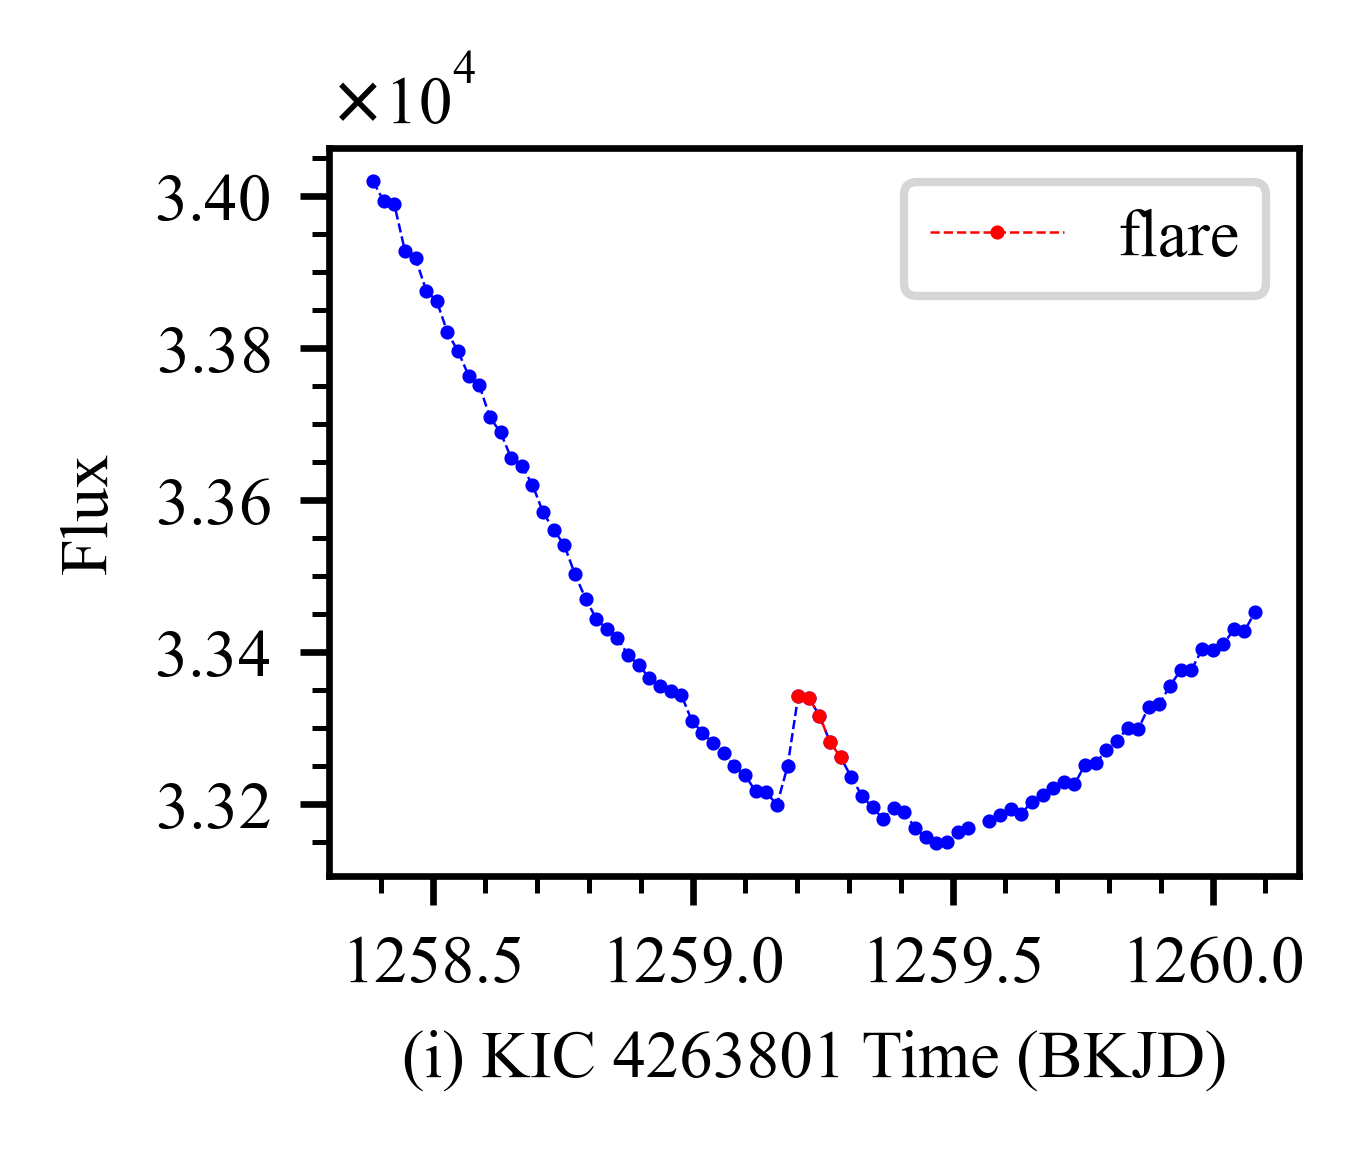

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

"""
绘制耀发事件
"""

def plot_flare(kic, lc_time, flux, start, end, save=False, plot_width=40):
    lc_time = np.nan_to_num(lc_time, nan=-9999)
    start_idx = np.argmin(np.abs(lc_time - start))
    end_idx = np.argmin(np.abs(lc_time - end))
    # print(start_idx, end_idx)

    plt.rc('font', size=8, family='Times New Roman')
    fig, ax = plt.subplots(figsize=(5.3/2.54, 4/2.54), dpi=600)
    width = plot_width
    ax.plot(lc_time[start_idx-width: end_idx+width], flux[start_idx-width: end_idx+width], 'b--o', linewidth=0.3, ms=0.7)
    ax.plot(lc_time[start_idx: end_idx+1], flux[start_idx: end_idx+1], 'r--o', linewidth=0.3, ms=0.7, label='flare')

    ax.set_xlabel('(i) KIC {} Time (BKJD)'.format(kic), fontsize=8, fontfamily='Times New Roman', fontstyle='normal')
    ax.set_ylabel('Flux', fontsize=8, fontfamily='Times New Roman', fontstyle='normal')
    ax.legend()
    ax.minorticks_on()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

    if save:
        # os.makedirs('./tmp')
        fig.savefig('tmp/kic_{}_start_{}_end_{}.png'.format(kic, start, end))
    
    plt.show()

kic, sci_data_set_name, file, start,  end, duration, energy, quarter = data[6]['flare_ev'].iloc[10]
file = os.path.join('/mnt/remote/Kepler/lightcurves/', file)
with fits.open(file) as f:
    lc_time, flux = f[1].data['TIME'], f[1].data['PDCSAP_FLUX']
plot_flare(kic, lc_time, flux, start, end, save=False, plot_width=40)

In [27]:
obs_spec = data[6]['obs_spec']
obs_spec = obs_spec.reset_index()

# 获取目标星光谱观测的文件路径列表
spec_files = []
for i in range(len(obs_spec)):
    obsdate, lmjd, planid, spid, fiberid = obs_spec[['obsdate', 'lmjd', 'planid', 'spid', 'fiberid']].iloc[i]
    obsdate = obsdate.replace('-', '')
    spid = str(spid).zfill(2)
    fiberid = str(fiberid).zfill(3)
    file = 'spec-{}-{}_sp{}-{}.fits'.format(lmjd, planid, spid, fiberid)
    file = os.path.join('/mnt/remote/lamost/spectra_v2.9.8/{}/{}'.format(obsdate, planid), file)
    spec_files.append(file)

spec_files

['/mnt/remote/lamost/spectra_v2.9.8/20120615/kepler05B56094/spec-56094-kepler05B56094_sp09-019.fits',
 '/mnt/remote/lamost/spectra_v2.9.8/20120617/kepler08B56096_1/spec-56096-kepler08B56096_1_sp10-027.fits']

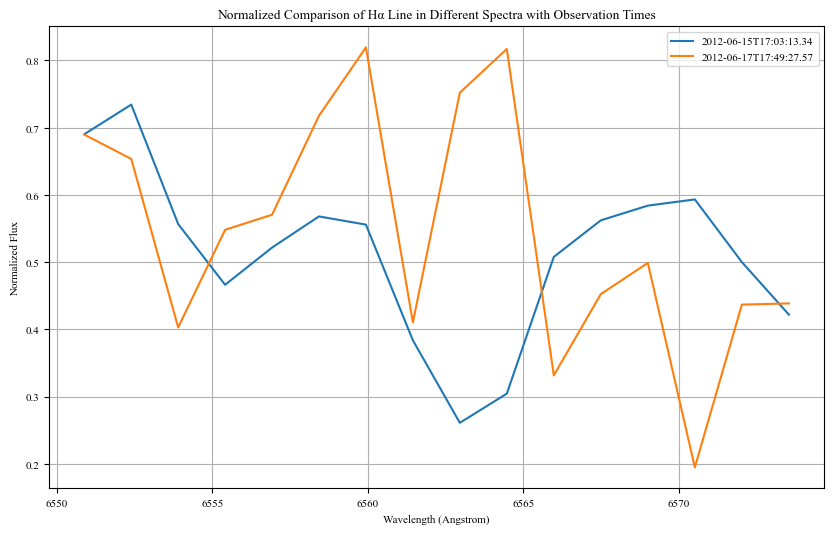

In [28]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

def extract_halpha_flux_and_time(fits_file):
    with fits.open(fits_file) as hdul:
        flux = hdul[0].data
        header = hdul[0].header

        coeff0 = header['COEFF0']
        coeff1 = header['COEFF1']
        naxis1 = header['NAXIS1']
        log_wavelength = coeff0 + coeff1 * np.arange(naxis1)
        wavelength = 10**log_wavelength

        # 读取观测时间
        observation_time = header.get('DATE-OBS', 'Unknown')

    wavelength_min = 6550
    wavelength_max = 6575

    flux[0] = (flux[0] - np.nanmean(flux[0])) / np.nanstd(flux[0])

    mask = (wavelength >= wavelength_min) & (wavelength <= wavelength_max)
    selected_wavelength = wavelength[mask]
    selected_flux = flux[0][mask]

    return selected_wavelength, selected_flux, observation_time

plt.figure(figsize=(10, 6))

for fits_file in spec_files:
    wavelength, flux, obs_time = extract_halpha_flux_and_time(fits_file)
    plt.plot(wavelength, flux, label=obs_time)

plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Flux')
plt.title('Normalized Comparison of Hα Line in Different Spectra with Observation Times')
plt.grid(True)
plt.legend()
plt.show()